# **Import packages**

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import keras
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.utils import resample
import string
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import TensorBoard, EarlyStopping
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
from tensorflow.keras.layers import (
    Input,
    Conv1D,
    Conv2D,
    Flatten,
    BatchNormalization,
    SpatialDropout1D,
    MaxPooling1D,
    TimeDistributed,
    MaxPooling2D,
    GlobalMaxPooling2D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    Embedding,
    LSTM,
    Bidirectional
)
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import metrics 
import itertools
from itertools import cycle
from sklearn.metrics import classification_report, auc

# **Define Preprocessing methods**

In [30]:
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [31]:
class Preprocessing():
    
    def __init__(self,  **kwargs):
        super().__init__(**kwargs)


    def tokenize(self, X):
        
        treebank = nltk.tokenize.TreebankWordTokenizer()
        X_tokenized=[treebank.tokenize(sentence) for sentence in X]  
        return X_tokenized


    def remove_stopwords(self, X):
        
        stopwords=nltk.corpus.stopwords.words('english') + ['@']
        X_without_stopwords = []

        for sentence in X:
            temp = [word for word in sentence if not word in stopwords]
            X_without_stopwords.append(temp) 

        return X_without_stopwords


    def stem(self, X,type='porter'):

        if type == 'porter':
            stemmer= nltk.stem.PorterStemmer()
        elif type == 'snowball':
            stemmer = nltk.stem.SnowballStemmer()
        elif type == 'lancaster':
            stemmer = nltk.stem.LancasterStemmer()    
            
        X_stemmed = []
        
        for sentence in X:
            temp = [stemmer.stem(word) for word in sentence]
            X_stemmed.append(temp)

        return X_stemmed 



    def get_wordnet_pos(self, treebank_tag):
        
            if treebank_tag.startswith('J'):
                return 'a'
            elif treebank_tag.startswith('V'):
                return 'v'
            elif treebank_tag.startswith('N'):
                return 'n'
            elif treebank_tag.startswith('R'):
                return 'r'
            else:
                return 'n'


    def lemmatize(self, X):

        lemmatizer = nltk.stem.WordNetLemmatizer()
        X_pos = []
        X_lemmatized = []

        for sentence in X :
            temp = nltk.pos_tag(sentence)
            X_pos.append(temp)  

        for sentence in X_pos :
            temp = [ lemmatizer.lemmatize(word[0],pos=self.get_wordnet_pos(word[1])) for word in sentence]
            X_lemmatized.append(temp)  
            
        return X_lemmatized    
    

    def CleanFeatures(self, sentences):
    
        sentences = sentences.apply(lambda sequence:
                                                [ltrs.lower() for ltrs in sequence if ltrs not in string.punctuation])

        sentences = sentences.apply(lambda wrd: ''.join(wrd))
        sentences = self.tokenize (sentences)
        sentences = self.remove_stopwords (sentences)
        sentences = self.lemmatize (sentences)
        sentences_clean = []
        
        for sentence in sentences:
            temp = " ".join(sentence)
            sentences_clean.append(temp)
        return sentences_clean

# **Load and prepare data**

In [32]:
dataset = pd.read_csv('/kaggle/input/ifnd-dataset/IFND.csv',encoding = "ISO-8859-1")

In [33]:
dataset.head()

,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE
2,4,LAC tensions: China's strategy behind delibera...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,TERROR,Oct-20,TRUE
3,5,India has signed 250 documents on Space cooper...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
4,6,Tamil Nadu chief minister's mother passes away...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,ELECTION,Oct-20,TRUE


In [34]:
dataset.shape

(56714, 7)

In [35]:
dataset = dataset[['Statement', 'Label']]

In [36]:
dataset.head()

,Statement,Label
0,"WHO praises India's Aarogya Setu app, says it ...",TRUE
1,"In Delhi, Deputy US Secretary of State Stephen...",TRUE
2,LAC tensions: China's strategy behind delibera...,TRUE
3,India has signed 250 documents on Space cooper...,TRUE
4,Tamil Nadu chief minister's mother passes away...,TRUE


In [37]:
dataset.isnull().sum()

Statement    0
Label        0
dtype: int64

In [38]:
dataset.describe()

,Statement,Label
count,56714,56714
unique,56340,2
top,Indian 3D Printer Project To Negatively Hit China,TRUE
freq,2,37800


Text(0.5, 1.0, 'Classes in the dataset')

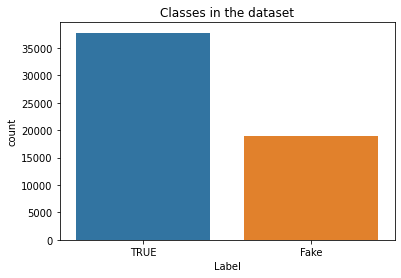

In [39]:
import seaborn as sns

sns.countplot(x='Label',data=dataset)
plt.title('Classes in the dataset')

In [40]:
Statement = dataset['Statement']
Label = dataset['Label']

In [41]:
preprocessing_obj = Preprocessing()
Statement = preprocessing_obj.CleanFeatures(Statement)

In [43]:
max_vocab=50000
tokenizer = Tokenizer(num_words=max_vocab,filters='@')
tokenizer.fit_on_texts(Statement)

In [44]:
Statement_seq = tokenizer.texts_to_sequences(Statement)

In [45]:
length=[]
for sentence in Statement_seq:
    length.append(len(sentence))
    
print('Average length of statements = '+str(np.mean(length)))

Average length of statements = 9.748033995133477


In [46]:
Statement = pad_sequences(Statement_seq, maxlen=20, padding='post', truncating='post')

print('Statement shape',Statement.shape)

Statement shape (56714, 20)


In [47]:
le = LabelEncoder()
Label = le.fit_transform(Label)
     
Label

array([1, 1, 1, ..., 0, 0, 0])

In [48]:
vocabulary = len(tokenizer.word_index)
     
vocabulary

40900

In [49]:
Statement = np.asarray(Statement)
Statement.shape

(56714, 20)

In [51]:
X_train, X_test, y_train, y_test = train_test_split (Statement,Label,test_size=0.3, shuffle=True)
X_test, X_val, y_test, y_val = train_test_split (X_test,y_test,test_size=0.5)

In [53]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(39699, 20) (39699,)
(8508, 20) (8508,)
(8507, 20) (8507,)


# **Load pre-trained word embeddings**

In [54]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-01-15 23:23:31--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-15 23:23:31--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-15 23:23:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [135]:
path_to_glove_file =  "glove.6B.200d.txt"


embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [185]:
num_tokens = vocabulary + 1
embedding_dim = 200
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 18584 words (22316 misses)


# **Build Model**

In [236]:
class BidirectionalLSTM(tf.keras.Model):
    def __init__(self,num_tokens,embedding_dim, embedding_matrix,dropout1=0.2, dropout2=0.5):
        super(BidirectionalLSTM, self).__init__()
        
        self.embedding_layer = Embedding(
            num_tokens,
            embedding_dim,
            embeddings_initializer=keras.initializers.Constant(embedding_matrix),
            trainable=False,
        )
        self.drop1 = Dropout(dropout1)
        self.bidirectional = Bidirectional(LSTM(200, dropout = 0.2))
        self.dense1 = Dense(64, activation='relu')
        self.out = Dense(2, activation="softmax")
        
        
    def call(self, inputs):
        
        x = self.embedding_layer(inputs)
        x = self.drop1(x)
        x = self.bidirectional(x)
        x = self.dense1(x)
        x = self.out(x)

        return x

In [237]:
def BidirectionalLSTM_():
    input_layer = Input(shape=(X_train.shape[1], ))
    x = BidirectionalLSTM(num_tokens=num_tokens,embedding_dim=200, embedding_matrix=embedding_matrix)(input_layer)
    return Model(inputs=input_layer, outputs=x)

model = BidirectionalLSTM_()

model.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        [(None, 20)]              0         
_________________________________________________________________
bidirectional_lstm_2 (Bidire (None, 2)                 8847594   
Total params: 8,847,594
Trainable params: 667,394
Non-trainable params: 8,180,200
_________________________________________________________________


In [238]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=["accuracy"])
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 3, mode = 'min', restore_best_weights = True)

In [239]:
history = model.fit(X_train, y_train, batch_size=512, validation_data=(X_val, y_val),epochs=50, callbacks=earlyStopping)

Epoch 1/50
78/78 [==============================] - 4s 24ms/step - loss: 0.3108 - accuracy: 0.8758 - val_loss: 0.2458 - val_accuracy: 0.9127
Epoch 2/50
78/78 [==============================] - 1s 15ms/step - loss: 0.2388 - accuracy: 0.9117 - val_loss: 0.2123 - val_accuracy: 0.9238
Epoch 3/50
78/78 [==============================] - 1s 16ms/step - loss: 0.2132 - accuracy: 0.9215 - val_loss: 0.1974 - val_accuracy: 0.9297
Epoch 4/50
78/78 [==============================] - 1s 15ms/step - loss: 0.1922 - accuracy: 0.9305 - val_loss: 0.1917 - val_accuracy: 0.9297
Epoch 5/50
78/78 [==============================] - 1s 15ms/step - loss: 0.1778 - accuracy: 0.9356 - val_loss: 0.1822 - val_accuracy: 0.9338
Epoch 6/50
78/78 [==============================] - 1s 15ms/step - loss: 0.1649 - accuracy: 0.9404 - val_loss: 0.1780 - val_accuracy: 0.9398
Epoch 7/50
78/78 [==============================] - 1s 15ms/step - loss: 0.1516 - accuracy: 0.9450 - val_loss: 0.1759 - val_accuracy: 0.9390
Epoch 8/50
78

# **Evaluation && Graphs**

In [240]:
class EvaluateModel():
    
    def __init__(self, classes=3, **kwargs):
        super().__init__(**kwargs)
        self.classes = classes


    def call(self):
        classes = self.classes
    

    def evaluate_model(self, model, X_test, y_test):
        
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        Accuracy = metrics.accuracy_score(y_test, y_pred)
        Sensitivity = metrics.recall_score(y_test, y_pred, average="macro")
        Precision = metrics.precision_score(y_test, y_pred, average="macro")
        F1_score = metrics.f1_score(y_test, y_pred, average="macro")
        Recall = metrics.recall_score(y_test, y_pred, average="macro")
        
        cm = metrics.confusion_matrix(y_test ,y_pred)

        tpr = float(cm[0][0])/np.sum(cm[0])
        fpr = float(cm[1][1])/np.sum(cm[1])

        auc_ = self.AUC(y_test, y_pred)
        
        print("Accuracy   =  ", Accuracy, "\n")
        print("Sensitvity =  ", Sensitivity, "\n")
        print("Precision  =  ", Precision, "\n")
        print("F1 Score   =  ", F1_score, "\n")
        print("Recall     =  ", Recall, "\n")
        print("fpr        =  ", fpr, "\n")
        print("tpr        =  ", tpr, "\n")
        print("AUC        =  ", auc_, "\n") 
        
        return Accuracy, Sensitivity, Precision, F1_score, Recall, fpr, tpr, auc_

    def plot_roc_curve(self, model, X_test, y_test, classes=3):
        y_pred = model.predict(X_test)
        y_test = to_categorical(y_test, classes)
        y_pred = to_categorical(np.argmax(y_pred, axis=1), classes)
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(classes):
            fpr[i], tpr[i], _ = metrics.roc_curve(y_test[:, i], y_pred[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        fpr["micro"], tpr["micro"], _ = metrics.roc_curve(
            y_test.ravel(), y_pred.ravel()
        )
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
        lw = 2
        all_fpr = np.unique(np.concatenate([fpr[i] for i in range(classes)]))

        mean_tpr = np.zeros_like(all_fpr)
        for i in range(classes):
            mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

        mean_tpr /= classes

        fpr["macro"] = all_fpr
        tpr["macro"] = mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Plot all ROC curves
        plt.figure(figsize=(10, 10))
        plt.plot(
            fpr["micro"],
            tpr["micro"],
            label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )

        plt.plot(
            fpr["macro"],
            tpr["macro"],
            label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
            color="navy",
            linestyle=":",
            linewidth=4,
        )

        colors = cycle(["aqua", "darkorange", "cornflowerblue"])
        for i, color in zip(range(classes), colors):
            plt.plot(
                fpr[i],
                tpr[i],
                color=color,
                lw=lw,
                label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
            )

        plt.plot([-0.05, 1], [0.0, 1], "k--", lw=lw)
        plt.xlim([-0.05, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Some extension of Receiver operating characteristic to multiclass")
        plt.legend(loc="lower right")
        plt.show()
        
    
    def AUC(self, actual_class, pred_class, average = "micro"):
    
        unique_class = set(actual_class)
        roc_auc_dict = {}
        for per_class in unique_class:

            other_class = [x for x in unique_class if x != per_class]

            
            new_actual_class = [0 if x in other_class else 1 for x in actual_class]
            new_pred_class = [0 if x in other_class else 1 for x in pred_class]

            
            roc_auc = metrics.roc_auc_score(new_actual_class, new_pred_class, average = average)
            roc_auc_dict[per_class] = roc_auc

        return roc_auc_dict

    def Confusion_Matrix(self, model, X_test, y_test, color='Blues'):
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)
        cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cnf_matrix)

        fig, ax = plt.subplots(figsize=(10, 10))
        disp.plot(ax=ax, cmap=color)
        plt.show()

    
    def Classification_Report(self, model, X_test, y_test):
        y_pred = model.predict(X_test)
        y_pred = np.argmax(y_pred, axis=1)

        return classification_report(y_test, y_pred)
    
    
    def Plot_History(self, history):
        pd.DataFrame(history.history)

        pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
        plt.title('Training Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('accuracy')

        pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
        plt.title('Model Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

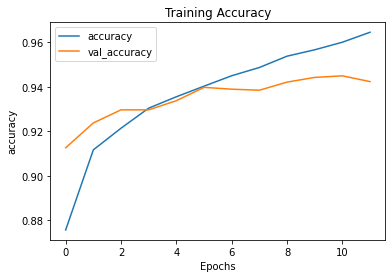

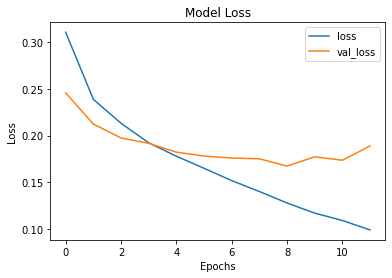

In [241]:
evaluate_obj = EvaluateModel()

evaluate_obj.Plot_History(history)

In [242]:
evaluate_obj.evaluate_model(model, X_test, y_test)

Accuracy   =   0.9422828259080757 

Sensitvity =   0.92443890182472 

Precision  =   0.9443661851251482 

F1 Score   =   0.9333789432082253 

Recall     =   0.92443890182472 

fpr        =   0.9771649393992623 

tpr        =   0.8717128642501777 

AUC        =   {0: 0.9244389018247201, 1: 0.92443890182472} 



(0.9422828259080757,
 0.92443890182472,
 0.9443661851251482,
 0.9333789432082253,
 0.92443890182472,
 0.9771649393992623,
 0.8717128642501777,
 {0: 0.9244389018247201, 1: 0.92443890182472})

In [243]:
evaluate_obj.Classification_Report(model, X_test, y_test)

'              precision    recall  f1-score   support\n\n           0       0.95      0.87      0.91      2814\n           1       0.94      0.98      0.96      5693\n\n    accuracy                           0.94      8507\n   macro avg       0.94      0.92      0.93      8507\nweighted avg       0.94      0.94      0.94      8507\n'

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


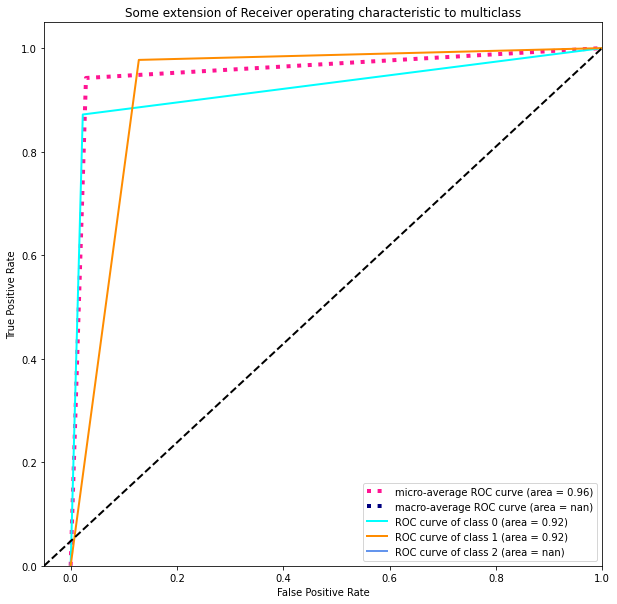

In [244]:
evaluate_obj.plot_roc_curve(model, X_test, y_test)

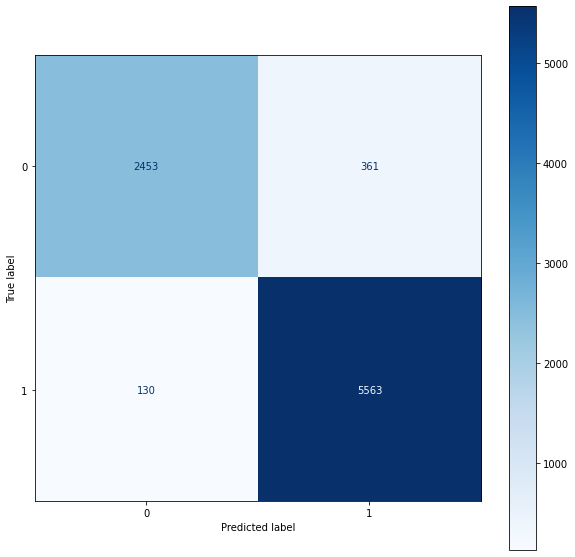

In [245]:
evaluate_obj.Confusion_Matrix(model, X_test, y_test)